## Load the saved GAN Model to rotate input images (oriented arbitarily in the sky) to face-on-Images

Input: Images at random orientation in the SKY

Ouput: FACE-on images

@author: Sayantan Auddy

Date:  29 jan 2023

In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import sys
import platform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import csv
import re ## For data manipulation
from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if torch.backends.mps.is_built() \
    else "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")

# print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: Linux-3.10.0-1160.88.1.el7.x86_64-x86_64-with-glibc2.30
PyTorch Version: 2.0.1
GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda:0


## Loading the testing data:

In [36]:
current_directory = os.getcwd()
path = current_directory + '/' # For local computer 
test_data = pd.read_csv(path+'data_folder/test.csv')
# test_data_attn = pd.read_csv(path+'data_folder_attention//test.csv') ## Not needed since the test data is same for the boht

In [37]:
test_data = test_data.drop('Unnamed: 0', axis=1)
test_data
# # test_data_attn 

,image_path,target
0,/project/6000733/sauddy3/GAN_rotation/Image_Ro...,/project/6000733/sauddy3/GAN_rotation/Image_Ro...
1,/project/6000733/sauddy3/GAN_rotation/Image_Ro...,/project/6000733/sauddy3/GAN_rotation/Image_Ro...
2,/project/6000733/sauddy3/GAN_rotation/Image_Ro...,/project/6000733/sauddy3/GAN_rotation/Image_Ro...
3,/project/6000733/sauddy3/GAN_rotation/Image_Ro...,/project/6000733/sauddy3/GAN_rotation/Image_Ro...
4,/project/6000733/sauddy3/GAN_rotation/Image_Ro...,/project/6000733/sauddy3/GAN_rotation/Image_Ro...
...,...,...
1518,/project/6000733/sauddy3/GAN_rotation/Image_Ro...,/project/6000733/sauddy3/GAN_rotation/Image_Ro...
1519,/project/6000733/sauddy3/GAN_rotation/Image_Ro...,/project/6000733/sauddy3/GAN_rotation/Image_Ro...
1520,/project/6000733/sauddy3/GAN_rotation/Image_Ro...,/project/6000733/sauddy3/GAN_rotation/Image_Ro...
1521,/project/6000733/sauddy3/GAN_rotation/Image_Ro...,/project/6000733/sauddy3/GAN_rotation/Image_Ro...


In [4]:
## Defining a custom class that returns image tensor and the corresponding label for a given index

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,dataframe,transform = None):
        self.df = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df["image_path"].iloc[index]
        target_filename = self.df["target"].iloc[index]
        image = Image.open(filename)
        target_image = Image.open(target_filename)
        
        if channels ==3:
            image = image.convert('RGB')#('L')# ## Converting to gray-scale with one channel        
            target_image = target_image.convert('RGB')#('L')#
        elif channels ==1:
            image = image.convert('L')# ## Converting to gray-scale with one channel        
            target_image = target_image.convert('L')#
#         print("THE SHAPE OF THE IMAGE",np.shape(image))
        else:
            print("Input channel can be 1 or 3 only")
            
        ## Cropping parameters selected for this dataset using trail and error method
        left = 105
        top = 55
        right = 480
        bottom = 430 
        
        # Cropped image of above dimension" # (It will not change original image)
        image = image.crop((left, top, right, bottom))
        target_image = target_image.crop((left, top, right, bottom))
        if self.transform is not None:
            image = self.transform(image)
            target_image = self.transform(target_image)

        return image,target_image

In [5]:
img_size = 256
batch_size = 1
channels = 3

params_test = {'batch_size':batch_size  ,
      'shuffle': False}
transform_custom = transforms.Compose([transforms.Resize(img_size),
transforms.ToTensor()])
test_set = CustomDataset(test_data,transform=transform_custom)
test_generator = torch.utils.data.DataLoader(test_set, **params_test )
print(len(test_set),len(test_generator))

1523 1523


In [38]:
 ########### GENERATING THE IMAGES USING THE GENERATOR ###############
        
################# Loading model without Attention ##################
gen_loaded = torch.jit.load('model_gen_rotate.pt')
gen_loaded.eval()
##################################################

################# Loading model without Attention ##################
gen_loaded_attn = torch.jit.load('model_scripted_attention.pt')
gen_loaded_attn.eval()
##################################################

RecursiveScriptModule(
  original_name=GeneratorUNet_attn
  (down1): RecursiveScriptModule(
    original_name=UNetDown
    (model): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=LeakyReLU)
    )
  )
  (down2): RecursiveScriptModule(
    original_name=UNetDown
    (model): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=InstanceNorm2d)
      (2): RecursiveScriptModule(original_name=LeakyReLU)
    )
  )
  (down3): RecursiveScriptModule(
    original_name=UNetDown
    (model): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=InstanceNorm2d)
      (2): RecursiveScriptModule(original_name=LeakyReLU)
    )
  )
  (down4): RecursiveScriptModule(
    original_name=UNetDown
  

In [51]:
from IPython.display import clear_output
def sample_image(batch_size,model):
    """
    input: Batch_size: Number of images to be displayed
           model : trained model
    Saves a grid of generated digits ranging from 0 to n_classes
    """
    # Sample images
    params_test = {'batch_size':batch_size  ,
      'shuffle': False}
    
    
    randomstart = 55 # 55
    
    ## Preparing the testtensor
    transform_custom = transforms.Compose([transforms.Resize(img_size),
    transforms.ToTensor()])
    test_set = CustomDataset(test_data[randomstart:randomstart+batch_size],transform=transform_custom)
    test_generator = torch.utils.data.DataLoader(test_set, **params_test )
    
    print(len(test_set),len(test_generator))

    
    
    for i, (imgs,targets) in enumerate(test_generator):
        sample_size = imgs.shape[0]
        print("shape of image",np.shape(imgs))    
        
        input_imgs = Variable(imgs.type(torch.FloatTensor).to(device))   
        print("shape of input image",np.shape(input_imgs))
        
        
        ################# MODEL ######################################
        gen_loaded = model          
        gen_imgs = gen_loaded(input_imgs)           
#         print("shape of generated image",np.shape(ge /n_imgs))  


        ################# FIGURE ######################################
        fig = plt.figure(figsize=(5, 10))
        # fig.text(0.038, 0.5, r"Iteration $\lambda$ = {} ".format(batches_done))
        axes = fig.subplots(batch_size, 3,sharex=False,  sharey=False)
        for i in range(batch_size):
            
            gen_img     =  Variable(gen_imgs[i].type(torch.FloatTensor).to("cpu"), requires_grad=False)
            input_img   =  Variable(input_imgs[i].type(torch.FloatTensor).to("cpu"), requires_grad=False)
            targets_img =  Variable(targets[i].type(torch.FloatTensor).to("cpu"), requires_grad=False)

            g_img = gen_img.permute(1, 2, 0).numpy()
            i_img = input_img.permute(1, 2, 0).numpy()
            t_img = targets_img .permute(1, 2, 0).numpy()
            axes[i][0].imshow(i_img)
            axes[i][1].imshow(g_img)
            axes[i][2].imshow(t_img)
            axes[0][0].set_title("Input")
            axes[0][1].set_title("Generated")
            axes[0][2].set_title("Target")
            axes[i][0].set_axis_off()
            axes[i][1].set_axis_off()
            axes[i][2].set_axis_off()
            
            clear_output() ## to remove the warning sign 

        
        # fig_D = "images/input_test.png"
        plt.savefig("sample_image.jpg",format='jpg',dpi=300)
        

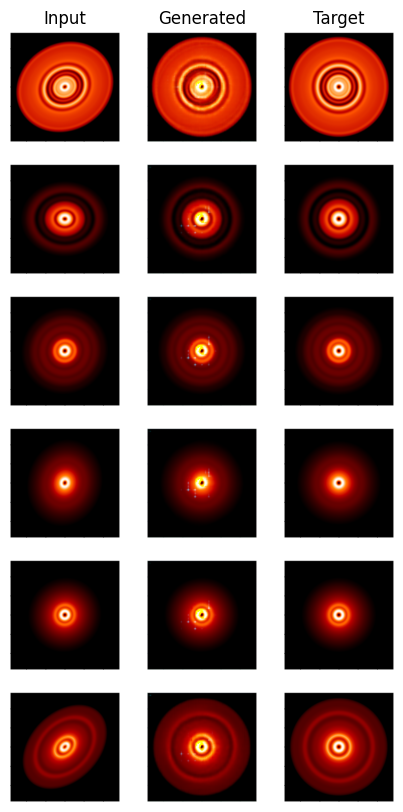

In [53]:
sample_image(batch_size=6,model=gen_loaded)

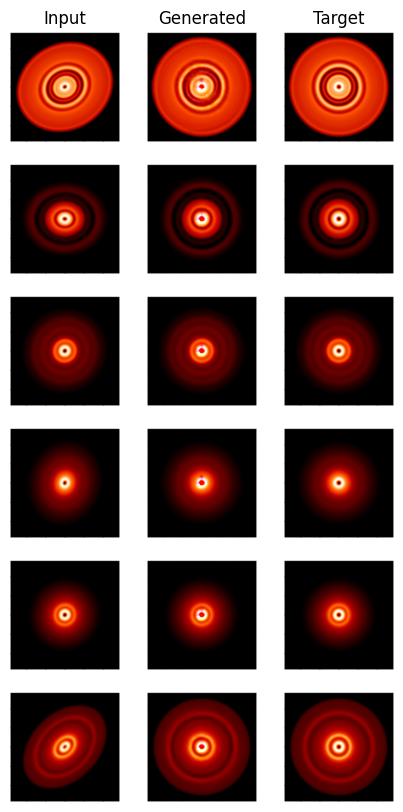

In [54]:
sample_image(batch_size=6,model=gen_loaded_attn)